In [1]:
import tensorflow as tf
print(f"Num Gpu Avaiable Are : {len(tf.config.list_physical_devices('GPU'))}")

Num Gpu Avaiable Are : 1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [4]:
data = r"Data\real_and_fake_face"

fake=[]
for file in os.listdir(data):
    if file[0] =='.':
        continue
    fake+=[file]
print(fake)
print(len(fake))
# for file1 in os.listdir(data_train):
#     if file1[0] =='.':
#         continue
#     fake+=[file1]
# print(fake)
# print(len(fake))

['training_fake', 'training_real']
2


In [7]:
img_height,img_width=256,256
batch_size=20

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2,rotation_range=0.2)
train_generator = train_datagen.flow_from_directory(data,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',subset="training"
                                               )
test_generator = train_datagen.flow_from_directory(data,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',subset="validation"
                                               )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [8]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [9]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## CNN

In [10]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (img_height,img_width,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0

In [11]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist=model.fit(train_generator,epochs=15,validation_data=test_generator)


Epoch 1/15
82/82 [==============================] - 469s 5s/step - loss: 0.8916 - accuracy: 0.5236 - precision: 0.5236 - recall: 0.5236 - sensitivity_at_specificity: 0.9057 - specificity_at_sensitivity: 0.9057 - val_loss: 0.6897 - val_accuracy: 0.5319 - val_precision: 0.5319 - val_recall: 0.5319 - val_sensitivity_at_specificity: 0.9216 - val_specificity_at_sensitivity: 0.9216
Epoch 2/15
82/82 [==============================] - 499s 6s/step - loss: 0.6941 - accuracy: 0.5279 - precision: 0.5279 - recall: 0.5279 - sensitivity_at_specificity: 0.9039 - specificity_at_sensitivity: 0.9039 - val_loss: 0.6908 - val_accuracy: 0.5294 - val_precision: 0.5294 - val_recall: 0.5294 - val_sensitivity_at_specificity: 0.5294 - val_specificity_at_sensitivity: 0.5294
Epoch 3/15
82/82 [==============================] - 454s 6s/step - loss: 0.6917 - accuracy: 0.5297 - precision: 0.5297 - recall: 0.5297 - sensitivity_at_specificity: 0.8267 - specificity_at_sensitivity: 0.8267 - val_loss: 0.6914 - val_accurac

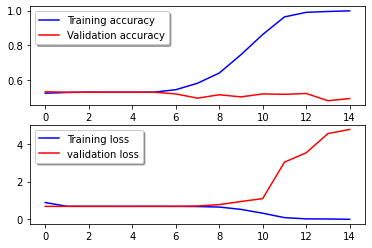

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

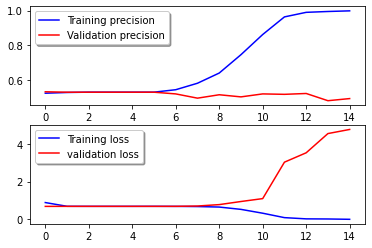

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['precision'], color='b', label="Training precision")
ax[0].plot(hist.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

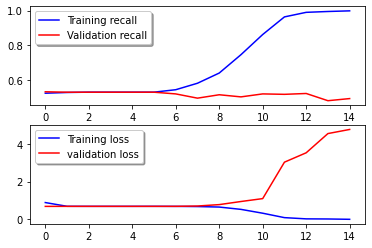

In [14]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['recall'], color='b', label="Training recall")
ax[0].plot(hist.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

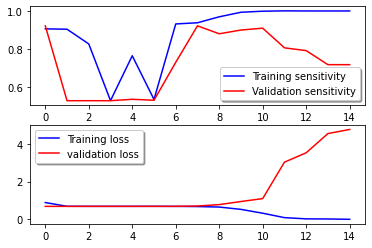

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

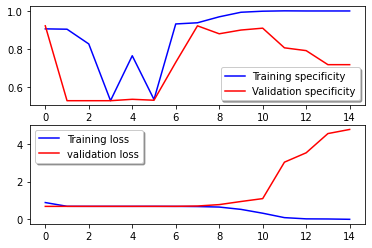

In [16]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [17]:
model.save("./models/CNN.h5")

In [18]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model_predict = model.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


408/408 - 43s


Confusion matrix, without normalization
[[ 86 106]
 [101 115]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

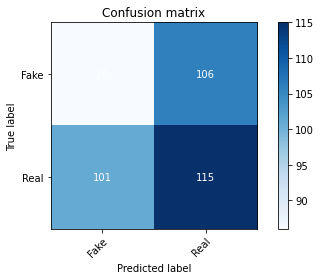

In [19]:
y_true = test_generator.classes
y_pred = model_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'],
                      title='Confusion matrix')

## VGG16

In [20]:
base_model1 =tf.keras.applications.VGG16(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(2, activation='sigmoid'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 14,747,906
Trainable params: 14,747,778
Non-trainable params: 128
________________________________________

In [21]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist1=model1.fit(train_generator,epochs=15,validation_data=test_generator)
model1.save("./models/vgg16.h5")

Epoch 1/15
82/82 [==============================] - 340s 4s/step - loss: 0.7467 - accuracy: 0.5126 - precision: 0.5039 - recall: 0.5071 - sensitivity_at_specificity: 0.9098 - specificity_at_sensitivity: 0.9005 - val_loss: 0.7377 - val_accuracy: 0.5294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_sensitivity_at_specificity: 0.8578 - val_specificity_at_sensitivity: 0.8186
Epoch 2/15
82/82 [==============================] - 667s 8s/step - loss: 0.7100 - accuracy: 0.5352 - precision: 0.5043 - recall: 0.5058 - sensitivity_at_specificity: 0.9039 - specificity_at_sensitivity: 0.9014 - val_loss: 0.9354 - val_accuracy: 0.5294 - val_precision: 0.5019 - val_recall: 0.9951 - val_sensitivity_at_specificity: 0.8922 - val_specificity_at_sensitivity: 0.8824
Epoch 3/15
82/82 [==============================] - 674s 8s/step - loss: 0.7121 - accuracy: 0.5181 - precision: 0.5155 - recall: 0.5077 - sensitivity_at_specificity: 0.8977 - specificity_at_sensitivity: 0.9014 - val_loss: 2.4187 - val

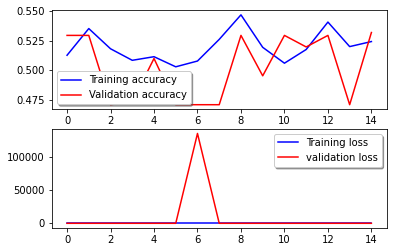

In [22]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

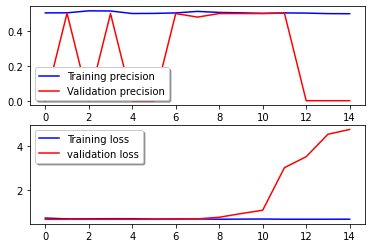

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['precision'], color='b', label="Training precision")
ax[0].plot(hist1.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

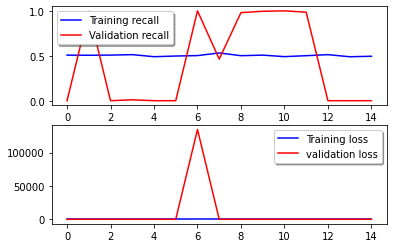

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['recall'], color='b', label="Training recall")
ax[0].plot(hist1.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

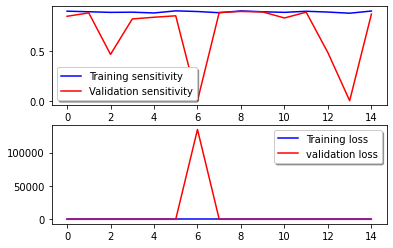

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist1.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

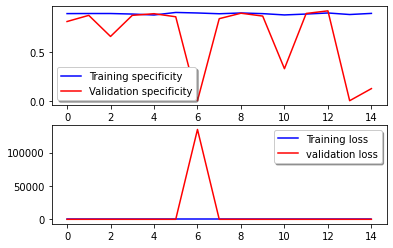

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist1.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist1.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist1.history['loss'], color='b', label="Training loss")
ax[1].plot(hist1.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [27]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model1_predict = model1.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


408/408 - 121s


Confusion matrix, without normalization
[[ 21 171]
 [ 30 186]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

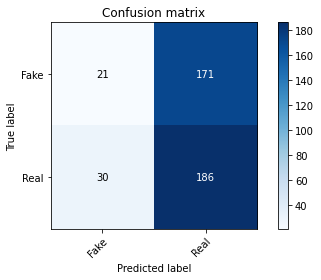

In [28]:
y_true = test_generator.classes
y_pred = model1_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'],
                      title='Confusion matrix')

## MOBILENET

In [29]:
base_model = tf.keras.applications.MobileNet(input_shape=(img_height,img_width, 3), include_top=False,
                          weights='imagenet')
model8 = Sequential()
model8.add(base_model)
model8.add(GlobalAveragePooling2D())
model8.add(Dense(64, activation='relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.2))
model8.add(Dense(2, activation='sigmoid'))
model8.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                65600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 3,294,850
Trainable params: 3,272,834
Non-trainable params: 22,016
_______________________________________

In [30]:
model8.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist8=model8.fit(train_generator,epochs=15,validation_data=test_generator)
model8.save("./models/mobilenet.h5")


Epoch 1/15
82/82 [==============================] - 320s 4s/step - loss: 0.8068 - accuracy: 0.6320 - precision: 0.5836 - recall: 0.4753 - sensitivity_at_specificity: 0.8001 - specificity_at_sensitivity: 0.9608 - val_loss: 1.4727 - val_accuracy: 0.5049 - val_precision: 0.4855 - val_recall: 0.2868 - val_sensitivity_at_specificity: 0.8848 - val_specificity_at_sensitivity: 0.8946
Epoch 2/15
82/82 [==============================] - 397s 5s/step - loss: 0.4858 - accuracy: 0.7930 - precision: 0.7071 - recall: 0.7110 - sensitivity_at_specificity: 0.9890 - specificity_at_sensitivity: 0.9859 - val_loss: 1.1939 - val_accuracy: 0.5270 - val_precision: 0.5353 - val_recall: 0.4828 - val_sensitivity_at_specificity: 0.9265 - val_specificity_at_sensitivity: 0.9265
Epoch 3/15
82/82 [==============================] - 462s 6s/step - loss: 0.3766 - accuracy: 0.8322 - precision: 0.7712 - recall: 0.8114 - sensitivity_at_specificity: 0.9988 - specificity_at_sensitivity: 0.9963 - val_loss: 1.6365 - val_accurac

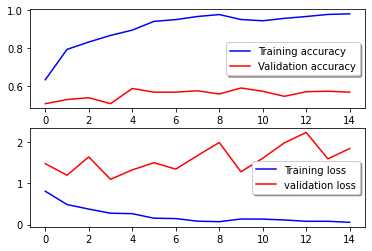

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['accuracy'], color='b', label="Training accuracy")
ax[0].plot(hist8.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

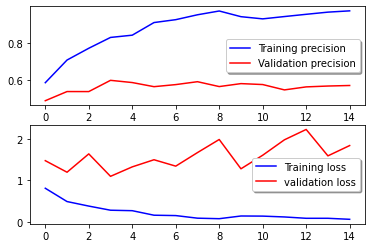

In [32]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['precision'], color='b', label="Training precision")
ax[0].plot(hist8.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

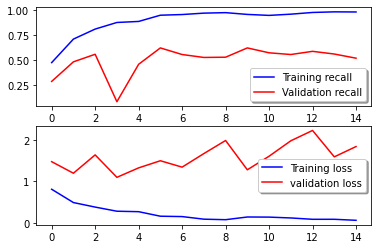

In [33]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['recall'], color='b', label="Training recall")
ax[0].plot(hist8.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

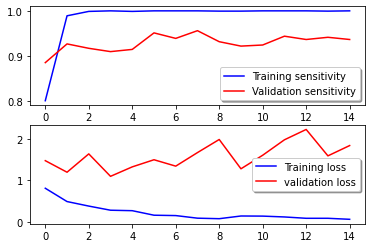

In [34]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist8.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

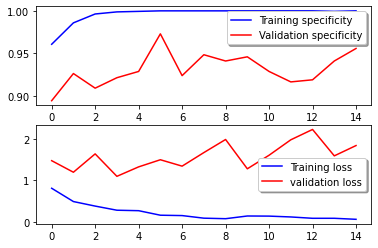

In [35]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist8.history['specificity_at_sensitivity'], color='b', label="Training specificity")
ax[0].plot(hist8.history['val_specificity_at_sensitivity'], color='r',label="Validation specificity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist8.history['loss'], color='b', label="Training loss")
ax[1].plot(hist8.history['val_loss'], color='r', label="validation loss",axes =ax[1])
legend = ax[1].legend(loc='best', shadow=True)

In [36]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model1_predict = model1.predict_generator(test_generator,steps = nb_samples, verbose=2)

c:\Users\0258\.conda\envs\deepfake\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


408/408 - 217s


Confusion matrix, without normalization
[[ 21 171]
 [ 31 185]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

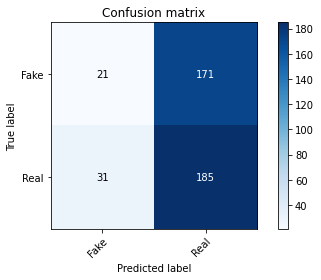

In [37]:
y_true = test_generator.classes
y_pred = model1_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Fake', 'Real'],
                      title='Confusion matrix')